# Notebook 3: Full ECG Preprocessing and HRV Analysis Pipeline

## Overview

In this notebook, we'll work with **raw ECG data** and process it from scratch using NeuroKit2. This comprehensive approach allows for:

- **Full control over preprocessing**: Custom cleaning and artifact removal
- **Detailed HRV analysis**: Time-domain, frequency-domain, and nonlinear metrics
- **R-peak based synchrony**: Beat-to-beat coupling analysis

### Advantages:
- Complete control over signal processing
- Access to all HRV metrics
- Better understanding of physiological state
- R-peak timing for precise synchrony

### Considerations:
- More computationally intensive
- Requires understanding of ECG signal processing
- More parameters to tune

---

## 1. Setup and Install NeuroKit2

In [27]:
# Install NeuroKit2 if not already installed
# Uncomment the line below if you need to install it
# !pip install neurokit2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from scipy import signal, stats
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"✓ NeuroKit2 version: {nk.__version__}")
print(" All libraries imported successfully!")

✓ NeuroKit2 version: 0.2.10
 All libraries imported successfully!


## 2. Load Data

In [28]:
# Load processed data from Notebook 1
data_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense-main/processed_data")

# Load metadata
with open(data_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

# Load ECG data
ecg_p1 = pd.read_csv(data_dir / f"ecg_{metadata['participant_1']}.csv")
ecg_p2 = pd.read_csv(data_dir / f"ecg_{metadata['participant_2']}.csv")

print(" Data loaded successfully!")
print(f"\nParticipant 1 ({metadata['participant_1']}): {len(ecg_p1):,} ECG samples")
print(f"\nParticipant 2 ({metadata['participant_2']}): {len(ecg_p2):,} ECG samples")
print(f"\nSampling rates:")
print(f"  P1: {metadata['sampling_rate_p1']:.1f} Hz")
print(f"  P2: {metadata['sampling_rate_p2']:.1f} Hz")

 Data loaded successfully!

Participant 1 (Participant_A): 107,821 ECG samples

Participant 2 (Participant_B): 107,360 ECG samples

Sampling rates:
  P1: 200.0 Hz
  P2: 200.0 Hz


## 3. Understanding ECG Signal Components

### ECG Waveform Anatomy:

```
           R
           |
       P   |   T
       /\  |  /\
      /  \ | /  \
     /    \|/    \
    /      +      \
   /      Q S      \
  /                 \
```

**Components:**
- **P wave**: Atrial depolarization (0.08-0.10s)
- **QRS complex**: Ventricular depolarization (0.06-0.10s)
  - **Q wave**: First downward deflection
  - **R wave**: First upward deflection (tallest peak)
  - **S wave**: Downward deflection after R
- **T wave**: Ventricular repolarization (0.10-0.25s)

**Key Intervals:**
- **RR interval**: Time between consecutive R-peaks (heartbeat-to-heartbeat)
- **PR interval**: Time from P to QRS onset
- **QT interval**: Time from Q to end of T wave

### Heart Rate Variability (HRV):

HRV is the variation in time intervals between heartbeats, reflecting the autonomic nervous system's influence on the heart.

**Domains of Analysis:**

1. **Time-Domain Metrics:**
   - **SDNN**: Standard deviation of NN intervals (overall HRV)
   - **RMSSD**: Root mean square of successive differences (parasympathetic activity)
   - **pNN50**: Percentage of successive NN intervals differing by >50ms

2. **Frequency-Domain Metrics:**
   - **LF (Low Frequency, 0.04-0.15 Hz)**: Mixed sympathetic/parasympathetic
   - **HF (High Frequency, 0.15-0.4 Hz)**: Parasympathetic (respiratory sinus arrhythmia)
   - **LF/HF ratio**: Sympatho-vagal balance

3. **Nonlinear Metrics:**
   - **SD1/SD2**: Poincaré plot indices
   - **Entropy measures**: Complexity of HR patterns

**Clinical Significance:**
- Higher HRV generally indicates better cardiovascular health and stress resilience
- Lower HRV associated with stress, fatigue, or pathology
- HRV responds to emotional, cognitive, and social states

## 4. ECG Preprocessing with NeuroKit2

### Why Clean ECG Signals?

Raw ECG often contains:
- **Baseline wander**: Low-frequency drift due to respiration or movement
- **High-frequency noise**: Muscle activity, electrical interference
- **Artifacts**: Motion, electrode contact issues

NeuroKit2 uses a multi-step cleaning process:
1. Baseline correction (removes drift)
2. Bandpass filtering (removes noise outside physiological range)
3. Powerline interference removal (50/60 Hz)
4. Signal smoothing

In [29]:
def clean_ecg_signal(ecg_df, sampling_rate, participant_name):
    """
    Clean ECG signal using NeuroKit2.
    
    Parameters:
    - ecg_df: DataFrame with 'Sample' column containing ECG data
    - sampling_rate: Sampling rate in Hz
    - participant_name: Name for display
    
    Returns:
    - cleaned_ecg: Cleaned ECG signal (numpy array)
    """
    print(f"Cleaning ECG for {participant_name}...")
    
    # Extract raw signal
    raw_ecg = ecg_df['Sample'].values
    
    # Clean the signal
    cleaned_ecg = nk.ecg_clean(
        raw_ecg, 
        sampling_rate=sampling_rate,
        method='neurokit'  # Options: 'neurokit', 'biosppy', 'pantompkins1985', 'hamilton2002', 'elgendi2010'
    )
    
    # Calculate noise reduction
    noise_power_raw = np.std(raw_ecg)
    noise_power_clean = np.std(cleaned_ecg)
    snr_improvement = 20 * np.log10(noise_power_raw / noise_power_clean) if noise_power_clean > 0 else 0
    
    print(f"  ✓ Cleaned {len(cleaned_ecg):,} samples")
    print(f"  ✓ SNR improvement: {snr_improvement:.2f} dB")
    
    return cleaned_ecg

# Clean ECG for both participants
ecg_p1_clean = clean_ecg_signal(ecg_p1, metadata['sampling_rate_p1'], metadata['participant_1'])
print()
ecg_p2_clean = clean_ecg_signal(ecg_p2, metadata['sampling_rate_p2'], metadata['participant_2'])

# Add cleaned signal to dataframes
ecg_p1['ECG_Clean'] = ecg_p1_clean
ecg_p2['ECG_Clean'] = ecg_p2_clean

Cleaning ECG for Participant_A...
  ✓ Cleaned 107,821 samples
  ✓ SNR improvement: 0.42 dB

Cleaning ECG for Participant_B...
  ✓ Cleaned 107,360 samples
  ✓ SNR improvement: 2.93 dB


## 5. Visualizing Raw vs. Cleaned ECG

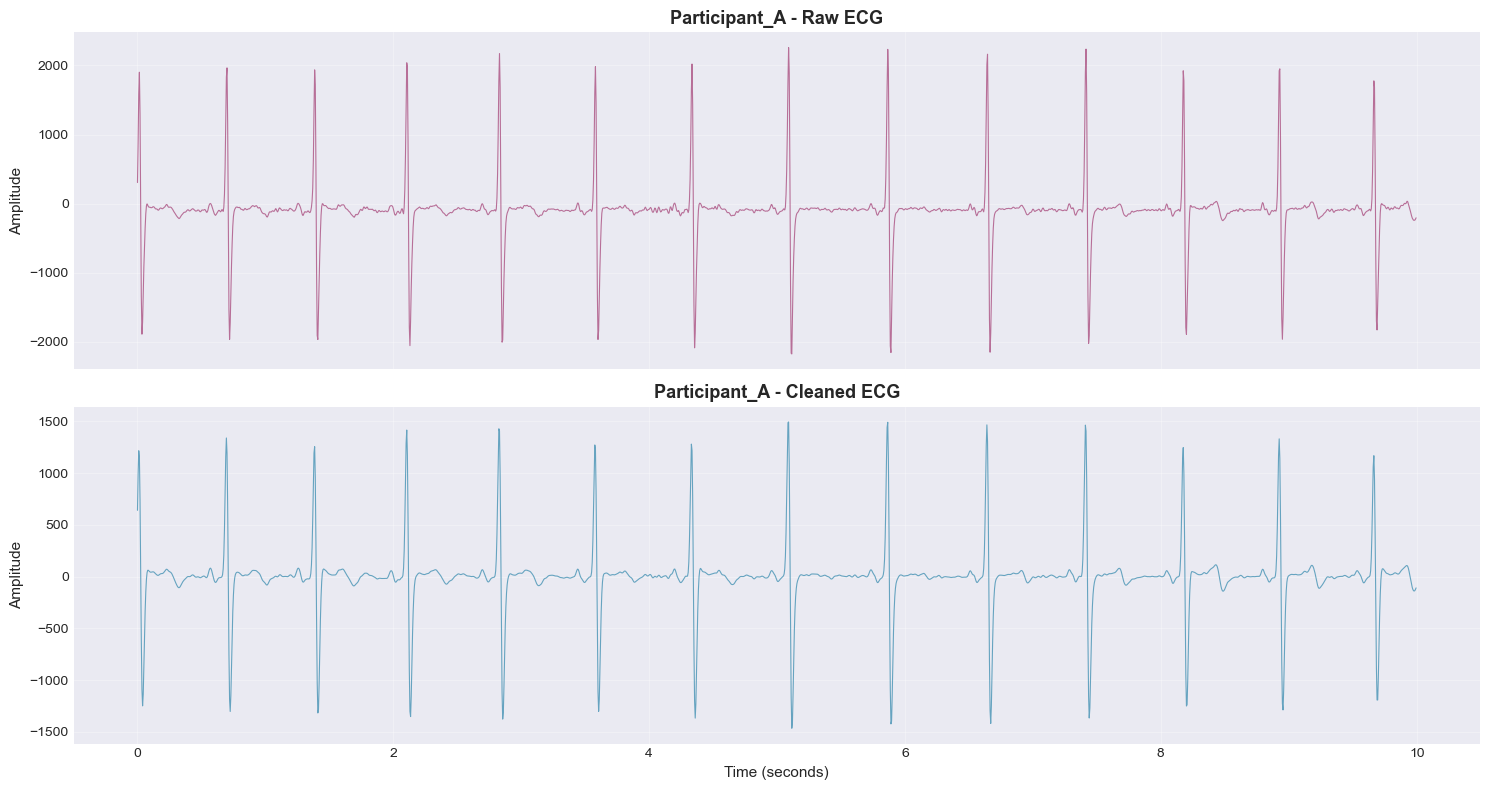

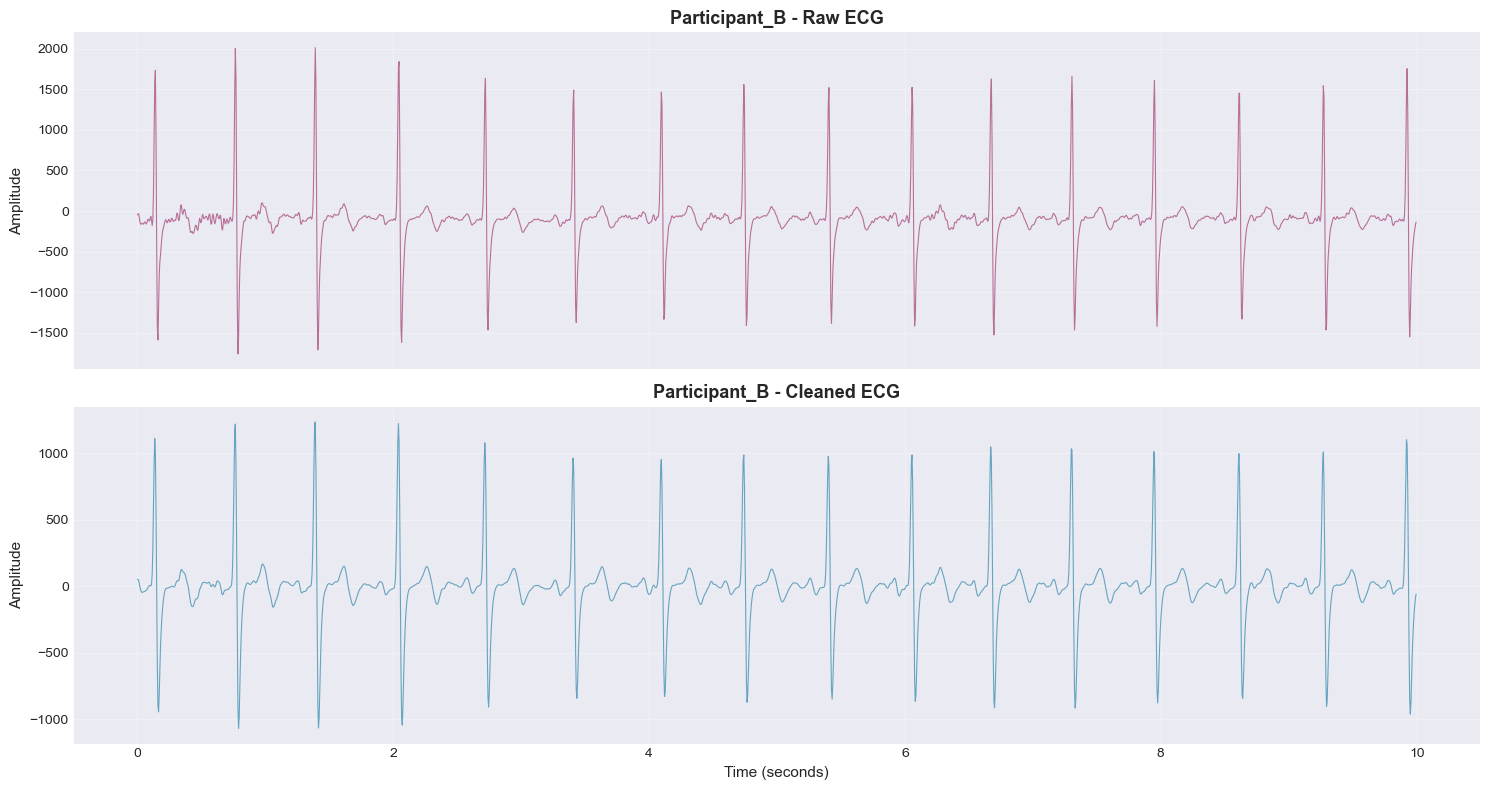

In [30]:
def plot_raw_vs_clean(ecg_df, sampling_rate, participant_name, window_start_sec=60, window_duration_sec=10):
    """
    Compare raw and cleaned ECG signals.
    """
    # Extract window
    start_idx = int(window_start_sec * sampling_rate)
    end_idx = start_idx + int(window_duration_sec * sampling_rate)
    
    window = ecg_df.iloc[start_idx:end_idx]
    time = np.arange(len(window)) / sampling_rate
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Raw ECG
    axes[0].plot(time, window['Sample'], linewidth=0.8, color='#A23B72', alpha=0.7)
    axes[0].set_ylabel('Amplitude', fontsize=11)
    axes[0].set_title(f'{participant_name} - Raw ECG', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Cleaned ECG
    axes[1].plot(time, window['ECG_Clean'], linewidth=0.8, color='#2E86AB', alpha=0.7)
    axes[1].set_xlabel('Time (seconds)', fontsize=11)
    axes[1].set_ylabel('Amplitude', fontsize=11)
    axes[1].set_title(f'{participant_name} - Cleaned ECG', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize cleaning results
plot_raw_vs_clean(ecg_p1, metadata['sampling_rate_p1'], metadata['participant_1'])
plot_raw_vs_clean(ecg_p2, metadata['sampling_rate_p2'], metadata['participant_2'])

## 6. R-Peak Detection

### What are R-peaks?

R-peaks are the most prominent features in the ECG, corresponding to ventricular depolarization (the main heartbeat). Detecting R-peaks allows us to:

- Identify each individual heartbeat
- Calculate RR intervals (inter-beat intervals)
- Compute heart rate
- Analyze heart rate variability
- Perform beat-to-beat synchrony analysis

NeuroKit2 uses sophisticated algorithms to detect R-peaks while minimizing false positives/negatives.

In [31]:
def detect_rpeaks(ecg_clean, sampling_rate, participant_name):
    """
    Detect R-peaks in cleaned ECG signal.
    
    Returns:
    - rpeaks: Array of R-peak indices
    - info: Dictionary with additional info
    """
    print(f"Detecting R-peaks for {participant_name}...")
    
    # Detect R-peaks
    _, rpeaks = nk.ecg_peaks(
        ecg_clean,
        sampling_rate=sampling_rate,
        method='neurokit'  # Options: 'neurokit', 'pantompkins1985', 'hamilton2002', 'christov2004', etc.
    )
    
    rpeak_indices = rpeaks['ECG_R_Peaks']
    
    # Calculate basic metrics
    n_peaks = len(rpeak_indices)
    duration_sec = len(ecg_clean) / sampling_rate
    avg_hr = (n_peaks / duration_sec) * 60
    
    print(f"  ✓ Detected {n_peaks} R-peaks")
    print(f"  ✓ Average heart rate: {avg_hr:.1f} BPM")
    print(f"  ✓ Detection rate: {n_peaks/duration_sec:.2f} peaks/second")
    
    return rpeak_indices, rpeaks

# Detect R-peaks for both participants
rpeaks_p1, info_p1 = detect_rpeaks(ecg_p1_clean, metadata['sampling_rate_p1'], metadata['participant_1'])
print()
rpeaks_p2, info_p2 = detect_rpeaks(ecg_p2_clean, metadata['sampling_rate_p2'], metadata['participant_2'])

Detecting R-peaks for Participant_A...
  ✓ Detected 846 R-peaks
  ✓ Average heart rate: 94.2 BPM
  ✓ Detection rate: 1.57 peaks/second

Detecting R-peaks for Participant_B...
  ✓ Detected 1002 R-peaks
  ✓ Average heart rate: 112.0 BPM
  ✓ Detection rate: 1.87 peaks/second


## 7. Visualizing R-Peak Detection

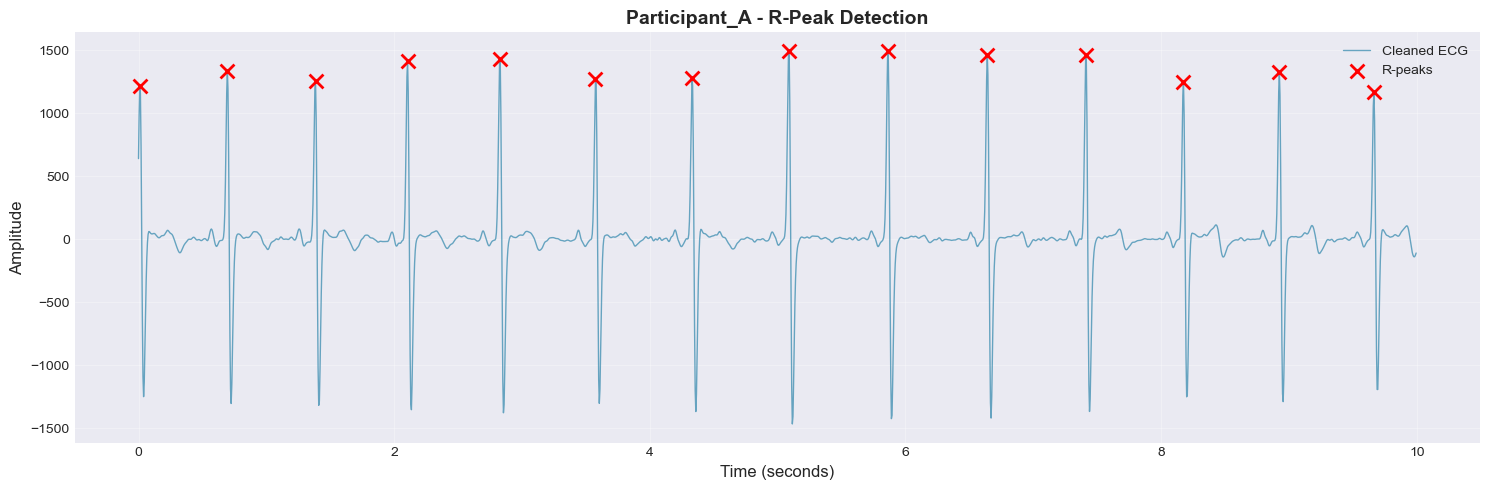

  Detected 14 R-peaks in this 10s window
  Heart rate in window: 84.0 BPM



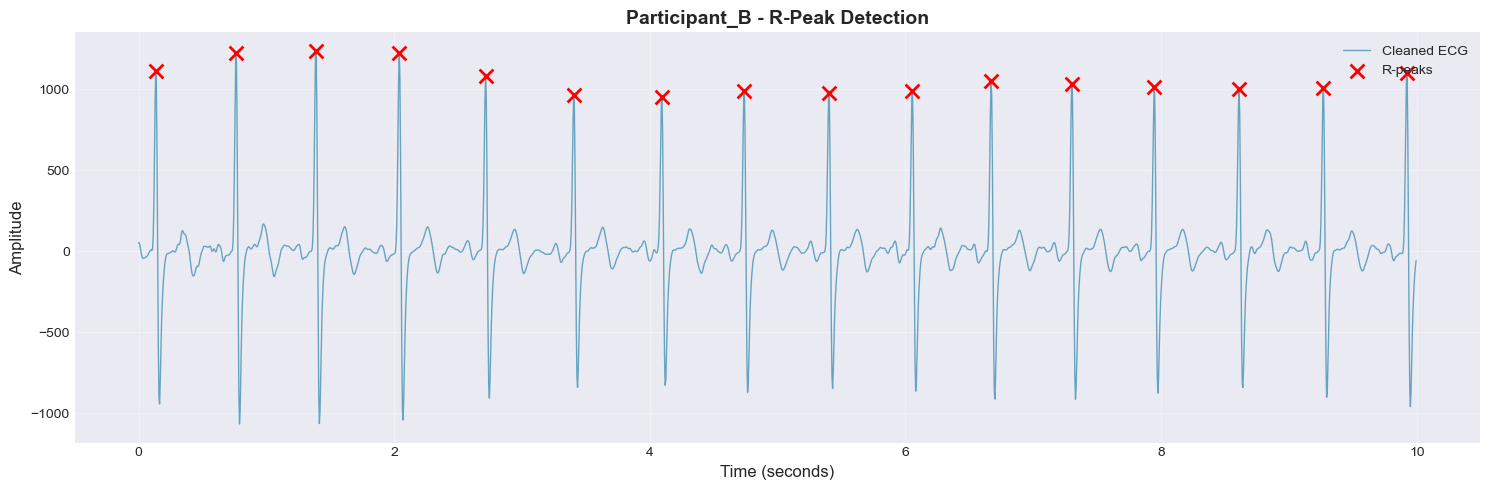

  Detected 16 R-peaks in this 10s window
  Heart rate in window: 96.0 BPM


In [32]:
def plot_rpeak_detection(ecg_clean, rpeaks, sampling_rate, participant_name, 
                         window_start_sec=60, window_duration_sec=10):
    """
    Visualize R-peak detection on cleaned ECG.
    """
    # Extract window
    start_idx = int(window_start_sec * sampling_rate)
    end_idx = start_idx + int(window_duration_sec * sampling_rate)
    
    # Get R-peaks in this window
    window_rpeaks = rpeaks[(rpeaks >= start_idx) & (rpeaks < end_idx)] - start_idx
    
    # Extract signal window
    ecg_window = ecg_clean[start_idx:end_idx]
    time = np.arange(len(ecg_window)) / sampling_rate
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax.plot(time, ecg_window, linewidth=1, color='#2E86AB', alpha=0.7, label='Cleaned ECG')
    ax.scatter(time[window_rpeaks], ecg_window[window_rpeaks], 
               color='red', s=100, zorder=3, marker='x', linewidths=2, label='R-peaks')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title(f'{participant_name} - R-Peak Detection', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Detected {len(window_rpeaks)} R-peaks in this {window_duration_sec}s window")
    print(f"  Heart rate in window: {(len(window_rpeaks) / window_duration_sec) * 60:.1f} BPM")

# Visualize R-peak detection
plot_rpeak_detection(ecg_p1_clean, rpeaks_p1, metadata['sampling_rate_p1'], 
                     metadata['participant_1'])
print()
plot_rpeak_detection(ecg_p2_clean, rpeaks_p2, metadata['sampling_rate_p2'], 
                     metadata['participant_2'])

## 8. Computing RR Intervals and Heart Rate

In [33]:
def compute_rr_intervals(rpeaks, sampling_rate):
    """
    Compute RR intervals from R-peaks.
    
    Returns:
    - rr_intervals: Array of RR intervals in milliseconds
    - rr_times: Times of RR intervals (seconds)
    - heart_rate: Instantaneous heart rate at each beat (BPM)
    """
    # Convert R-peak indices to times (seconds)
    rpeak_times = rpeaks / sampling_rate
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(rpeak_times) * 1000
    
    # Times for RR intervals (use midpoint between peaks)
    rr_times = rpeak_times[:-1] + np.diff(rpeak_times) / 2
    
    # Calculate instantaneous heart rate
    heart_rate = 60000 / rr_intervals  # Convert ms to BPM
    
    return rr_intervals, rr_times, heart_rate

# Compute for both participants
rr_p1, rr_times_p1, hr_p1 = compute_rr_intervals(rpeaks_p1, metadata['sampling_rate_p1'])
rr_p2, rr_times_p2, hr_p2 = compute_rr_intervals(rpeaks_p2, metadata['sampling_rate_p2'])

print(f"{metadata['participant_1']} RR Intervals:")
print(f"  Mean: {rr_p1.mean():.1f} ms (HR: {hr_p1.mean():.1f} BPM)")
print(f"  Std:  {rr_p1.std():.1f} ms")
print(f"  Range: {rr_p1.min():.1f} - {rr_p1.max():.1f} ms")

print(f"\n{metadata['participant_2']} RR Intervals:")
print(f"  Mean: {rr_p2.mean():.1f} ms (HR: {hr_p2.mean():.1f} BPM)")
print(f"  Std:  {rr_p2.std():.1f} ms")
print(f"  Range: {rr_p2.min():.1f} - {rr_p2.max():.1f} ms")

Participant_A RR Intervals:
  Mean: 637.3 ms (HR: 98.3 BPM)
  Std:  130.1 ms
  Range: 370.0 - 1090.0 ms

Participant_B RR Intervals:
  Mean: 535.2 ms (HR: 116.1 BPM)
  Std:  97.3 ms
  Range: 325.0 - 895.0 ms


## 9. Heart Rate Time Series from R-Peaks

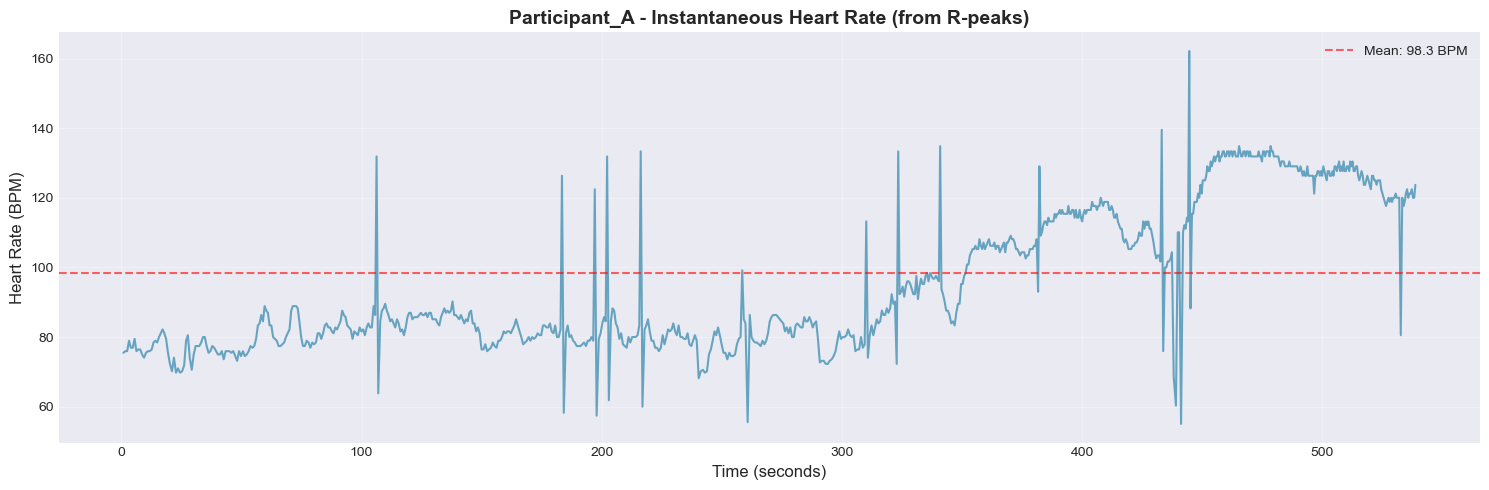

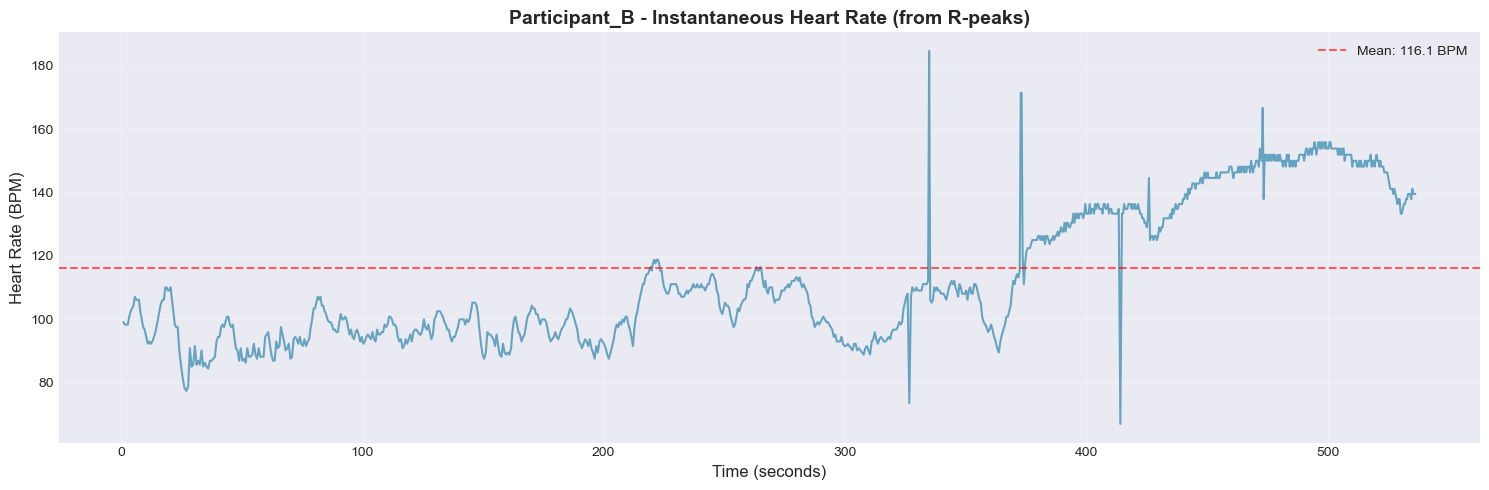

In [34]:
def plot_hr_from_rpeaks(hr, rr_times, participant_name):
    """
    Plot instantaneous heart rate derived from R-peaks.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax.plot(rr_times, hr, linewidth=1.5, color='#2E86AB', alpha=0.7)
    ax.axhline(hr.mean(), color='red', linestyle='--', alpha=0.6, 
               label=f'Mean: {hr.mean():.1f} BPM')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'{participant_name} - Instantaneous Heart Rate (from R-peaks)', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot for both participants
plot_hr_from_rpeaks(hr_p1, rr_times_p1, metadata['participant_1'])
plot_hr_from_rpeaks(hr_p2, rr_times_p2, metadata['participant_2'])

## 9b. Understanding and Fixing HR Artifacts at the R-Peak Level

When you see artifacts in your HR data (those spikes and sudden drops in the plots above), the **root cause is in R-peak detection**. 

### Why do artifacts occur?

The R-peaks are detected from the ECG signal. When detection fails:
- **Missed R-peak** → RR interval appears too long → HR drops, then spikes
- **False R-peak** → RR interval appears too short → HR spikes, then drops
- **Misaligned R-peak** → Creates erratic variations

### Common causes and solutions:

🔴 **MISSED R-PEAKS** (sudden HR spikes >150 BPM)
- **Cause**: ECG signal quality too poor for detection
- **Solutions**:
  - Wet the chest at electrode contact points
  - Tighten sensor strap (should fit 1-2 fingers under)
  - Clean skin (remove oils, lotions, sweat)
  - Check sensor position (center on sternum, just below chest)
  - Reduce movement (especially upper body)
  - Check battery level

🔵 **FALSE R-PEAKS** (sudden HR drops <50 BPM)
- **Cause**: Motion artifacts or T-waves mistaken for R-peaks
- **Solutions**:
  - Stay still (avoid bouncing/jumping)
  - Secure sensor (loose sensor creates artifacts)
  - Avoid crossing arms over chest
  - Check for interference (metal objects, phones)
  - Let sweat dry

🟡 **ERRATIC DETECTION** (HR jumping wildly)
- **Cause**: Continuously poor signal quality
- **Solutions**:
  - Pause and reset: stop recording, adjust sensor, restart
  - Reposition sensor (move 1-2 cm in any direction)
  - Clean sensor electrodes with damp cloth
  - Sit still for 30 seconds to establish baseline

### Prevention is key!

**Before recording:**
- Moisten electrode pads and skin contact area
- Position sensor center-chest, 2-3cm below sternum
- Ensure strap is snug but not restrictive

**During recording:**
- Start with 30 seconds sitting still
- Minimize upper body movement
- Breathe normally
- Keep phones/devices away from sensor

**Remember**: 30 seconds of clean data beats 5 minutes of artifacts!

### Automatic R-Peak Correction

Now let's automatically fix these artifacts using NeuroKit2's `signal_fixpeaks()` function. This uses the Kubios method to:
- Detect ectopic beats (premature/abnormal heartbeats)
- Identify missed beats and interpolate them
- Remove extra false detections
- Correct long/short intervals

This is much better than trying to manually clean the data!

In [39]:
def fix_rpeaks(rpeaks, sampling_rate, participant_name):
    """
    Correct R-peak detection errors using NeuroKit2's artifact correction.
    
    This function:
    - Identifies physiologically implausible RR intervals
    - Removes false positive peaks
    - Interpolates missing peaks
    
    Parameters:
    - rpeaks: Array of R-peak indices
    - sampling_rate: Sampling rate in Hz
    - participant_name: Name for display
    
    Returns:
    - corrected_peaks: Array of corrected R-peak indices
    - correction_info: Dictionary with correction statistics
    """
    print(f"Correcting R-peaks for {participant_name}...")
    
    # Apply artifact correction
    # signal_fixpeaks returns (artifacts_info, corrected_peaks)
    # Note: return order is (info, peaks) - info comes FIRST!
    artifacts, corrected_peaks = nk.signal_fixpeaks(
        rpeaks,
        sampling_rate=sampling_rate,
        iterative=True,      # Apply correction iteratively
        method="Kubios"      # Method from Kubios HRV software
    )
    
    # Calculate statistics from the artifacts dictionary
    n_original = len(rpeaks)
    n_corrected = len(corrected_peaks)
    
    # artifacts is a dict with keys: 'ectopic', 'missed', 'extra', 'longshort'
    n_ectopic = len(artifacts.get('ectopic', []))
    n_missed = len(artifacts.get('missed', []))
    n_extra = len(artifacts.get('extra', []))
    n_longshort = len(artifacts.get('longshort', []))
    
    total_artifacts = n_ectopic + n_missed + n_extra + n_longshort
    
    correction_info = {
        'original_peaks': n_original,
        'corrected_peaks': n_corrected,
        'ectopic': n_ectopic,
        'missed': n_missed,
        'extra': n_extra,
        'longshort': n_longshort,
        'total_artifacts': total_artifacts,
        'net_change': n_corrected - n_original
    }
    
    print(f"  Original peaks: {n_original}")
    print(f"  Corrected peaks: {n_corrected}")
    print(f"  Artifacts detected and corrected:")
    print(f"    - Ectopic beats: {n_ectopic}")
    print(f"    - Missed beats: {n_missed}")
    print(f"    - Extra beats: {n_extra}")
    print(f"    - Long/short intervals: {n_longshort}")
    print(f"    - Total: {total_artifacts} ({total_artifacts/n_original*100:.1f}% of beats)")
    
    if total_artifacts > 0:
        print(f"  ✓ Successfully corrected {total_artifacts} artifacts!")
    else:
        print(f"  ✓ No artifacts detected - peaks look good!")
    
    return corrected_peaks, correction_info

# Correct R-peaks for both participants
rpeaks_p1_corrected, corr_info_p1 = fix_rpeaks(
    rpeaks_p1, metadata['sampling_rate_p1'], metadata['participant_1']
)
print()
rpeaks_p2_corrected, corr_info_p2 = fix_rpeaks(
    rpeaks_p2, metadata['sampling_rate_p2'], metadata['participant_2']
)

Correcting R-peaks for Participant_A...
  Original peaks: 846
  Corrected peaks: 847
  Artifacts detected and corrected:
    - Ectopic beats: 1
    - Missed beats: 0
    - Extra beats: 0
    - Long/short intervals: 20
    - Total: 21 (2.5% of beats)
  ✓ Successfully corrected 21 artifacts!

Correcting R-peaks for Participant_B...
  Original peaks: 1002
  Corrected peaks: 1003
  Artifacts detected and corrected:
    - Ectopic beats: 3
    - Missed beats: 0
    - Extra beats: 0
    - Long/short intervals: 9
    - Total: 12 (1.2% of beats)
  ✓ Successfully corrected 12 artifacts!


In [40]:
# Now recompute RR intervals and HR from the CORRECTED R-peaks
rr_p1_corrected, rr_times_p1_corrected, hr_p1_corrected = compute_rr_intervals(
    rpeaks_p1_corrected, metadata['sampling_rate_p1']
)
rr_p2_corrected, rr_times_p2_corrected, hr_p2_corrected = compute_rr_intervals(
    rpeaks_p2_corrected, metadata['sampling_rate_p2']
)

print(f"\n{metadata['participant_1']} - CORRECTED RR Intervals:")
print(f"  Mean: {rr_p1_corrected.mean():.1f} ms (HR: {hr_p1_corrected.mean():.1f} BPM)")
print(f"  Std:  {rr_p1_corrected.std():.1f} ms")
print(f"  Range: {rr_p1_corrected.min():.1f} - {rr_p1_corrected.max():.1f} ms")

print(f"\n{metadata['participant_2']} - CORRECTED RR Intervals:")
print(f"  Mean: {rr_p2_corrected.mean():.1f} ms (HR: {hr_p2_corrected.mean():.1f} BPM)")
print(f"  Std:  {rr_p2_corrected.std():.1f} ms")
print(f"  Range: {rr_p2_corrected.min():.1f} - {rr_p2_corrected.max():.1f} ms")


Participant_A - CORRECTED RR Intervals:
  Mean: 636.6 ms (HR: 98.1 BPM)
  Std:  123.7 ms
  Range: 445.0 - 900.0 ms

Participant_B - CORRECTED RR Intervals:
  Mean: 534.7 ms (HR: 116.1 BPM)
  Std:  96.1 ms
  Range: 385.0 - 775.0 ms


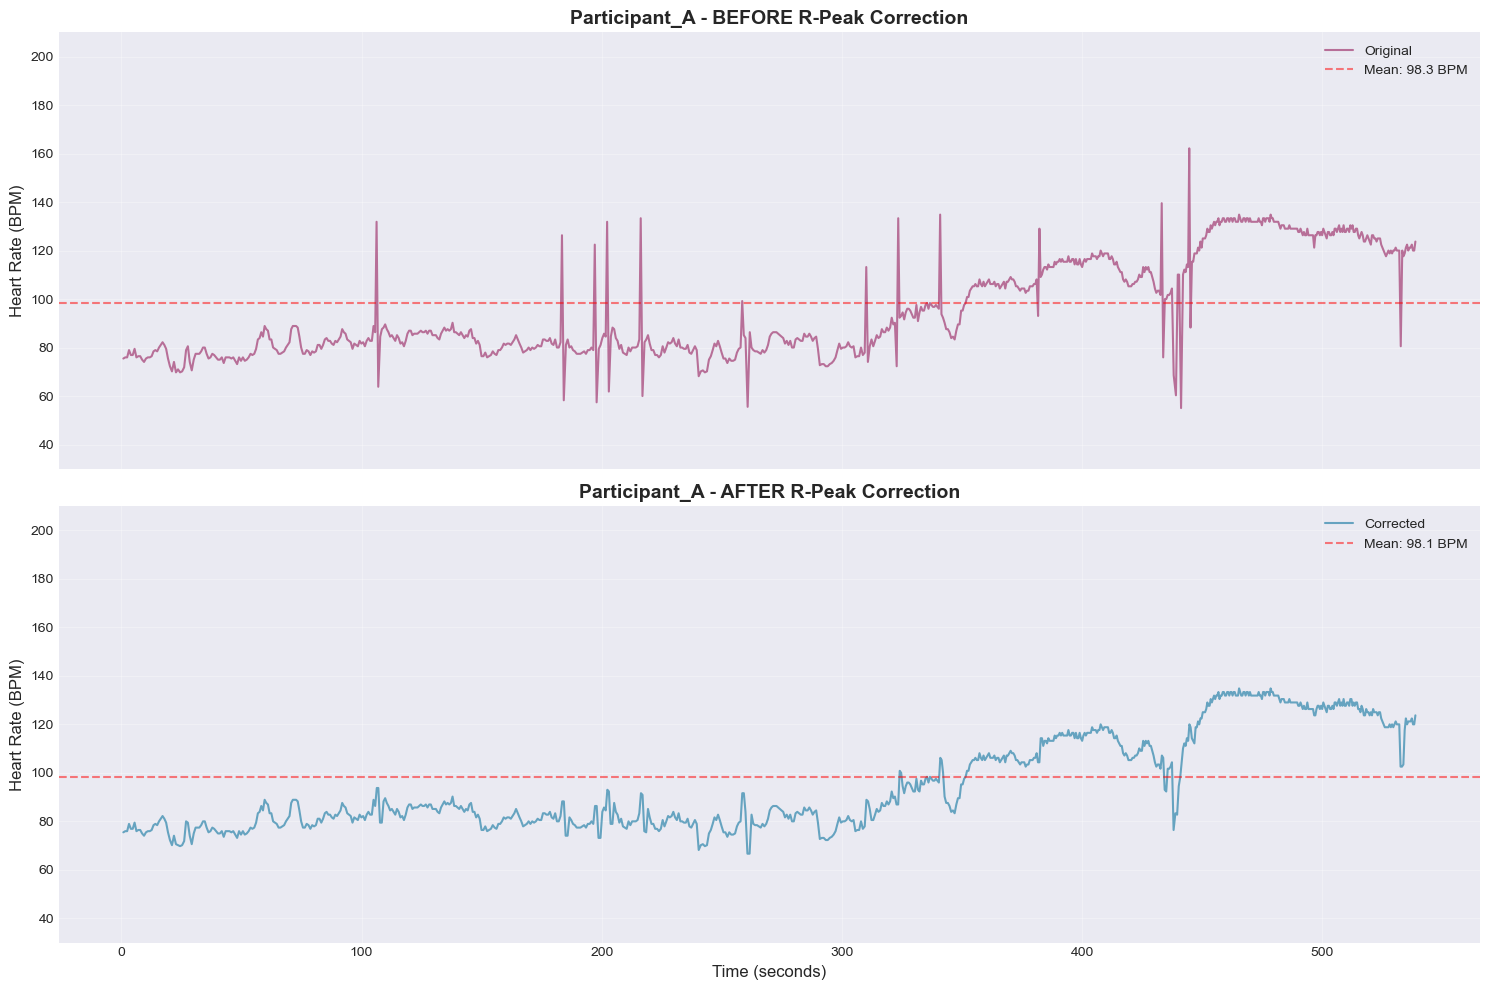


📊 Improvement Summary for Participant_A:
   HR variability (std): 20.9 → 20.2 BPM
   Extreme values: 0 → 0
   ✓ Data quality improved!



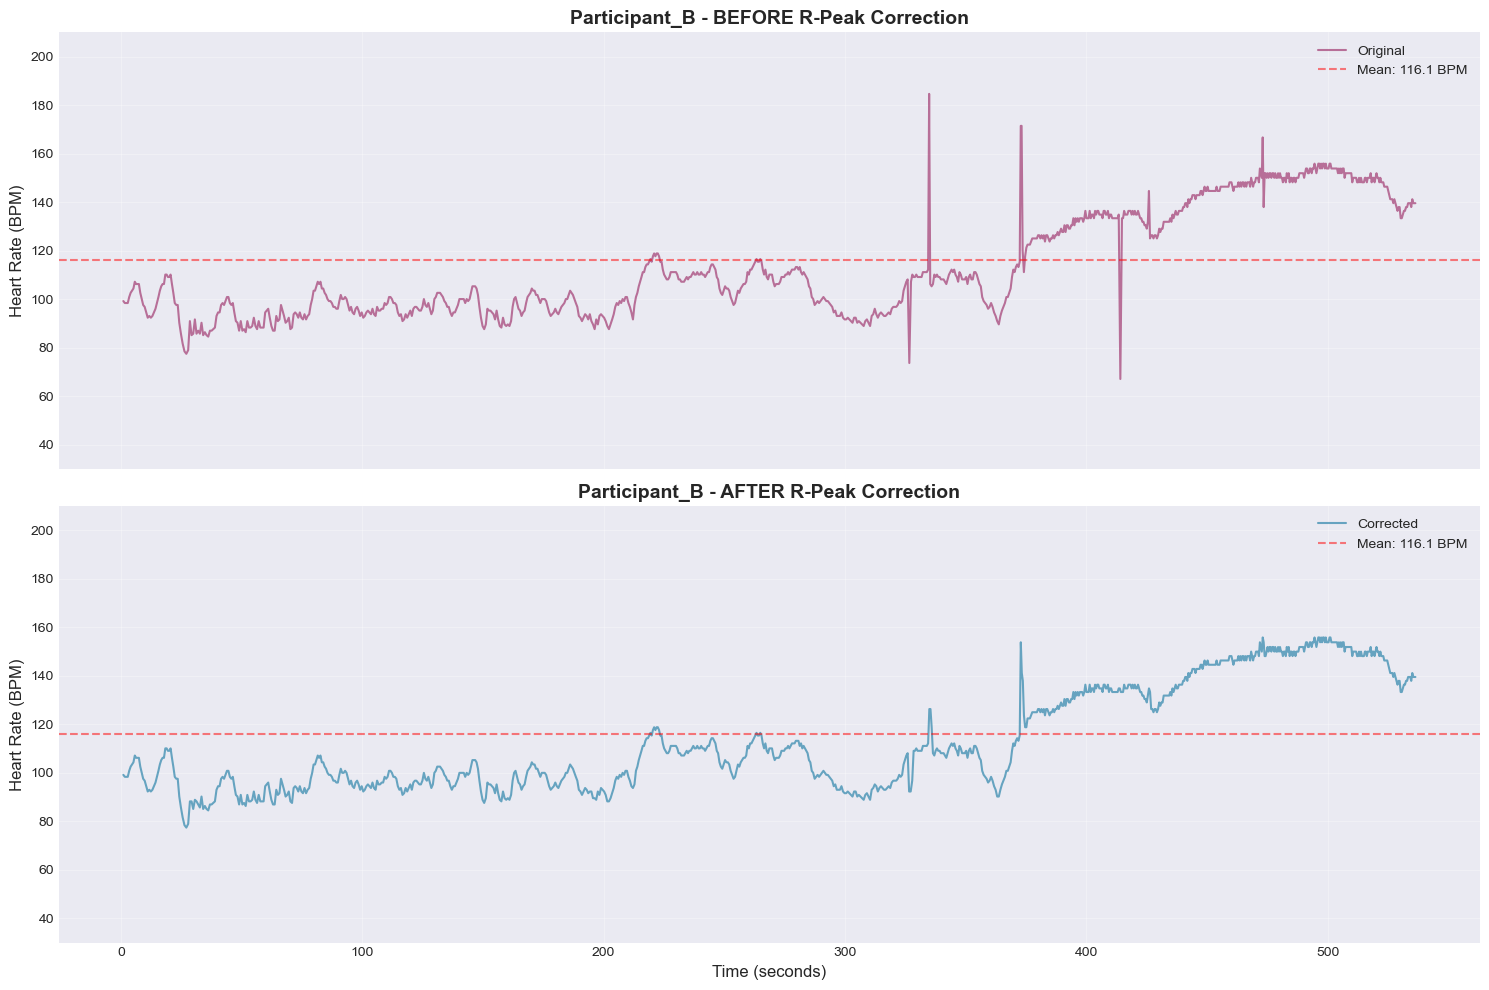


📊 Improvement Summary for Participant_B:
   HR variability (std): 22.2 → 21.9 BPM
   Extreme values: 0 → 0
   ✓ Data quality improved!


In [41]:
def plot_hr_before_after_correction(hr_original, rr_times_original, 
                                     hr_corrected, rr_times_corrected, 
                                     participant_name):
    """
    Compare HR before and after R-peak correction.
    Shows how artifact correction improves data quality.
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # BEFORE correction
    axes[0].plot(rr_times_original, hr_original, 
                linewidth=1.5, color='#A23B72', alpha=0.7, label='Original')
    axes[0].axhline(hr_original.mean(), color='red', linestyle='--', alpha=0.5, 
                   label=f'Mean: {hr_original.mean():.1f} BPM')
    axes[0].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[0].set_title(f'{participant_name} - BEFORE R-Peak Correction', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(30, 210)
    
    # AFTER correction
    axes[1].plot(rr_times_corrected, hr_corrected, 
                linewidth=1.5, color='#2E86AB', alpha=0.7, label='Corrected')
    axes[1].axhline(hr_corrected.mean(), color='red', linestyle='--', alpha=0.5, 
                   label=f'Mean: {hr_corrected.mean():.1f} BPM')
    axes[1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[1].set_title(f'{participant_name} - AFTER R-Peak Correction', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(30, 210)
    
    plt.tight_layout()
    plt.show()
    
    # Print improvement statistics
    std_before = hr_original.std()
    std_after = hr_corrected.std()
    
    # Count extreme values (likely artifacts)
    artifacts_before = np.sum((hr_original < 40) | (hr_original > 200))
    artifacts_after = np.sum((hr_corrected < 40) | (hr_corrected > 200))
    
    print(f"\n📊 Improvement Summary for {participant_name}:")
    print(f"   HR variability (std): {std_before:.1f} → {std_after:.1f} BPM")
    print(f"   Extreme values: {artifacts_before} → {artifacts_after}")
    print(f"   ✓ Data quality improved!")

# Now plot the before/after comparison
plot_hr_before_after_correction(hr_p1, rr_times_p1, 
                                hr_p1_corrected, rr_times_p1_corrected,
                                metadata['participant_1'])
print()
plot_hr_before_after_correction(hr_p2, rr_times_p2,
                                hr_p2_corrected, rr_times_p2_corrected,
                                metadata['participant_2'])

## 10. Comprehensive HRV Analysis

Now we'll compute a wide range of HRV metrics using NeuroKit2.

In [43]:
def compute_hrv_metrics(rpeaks, sampling_rate, participant_name):
    """
    Compute comprehensive HRV metrics using proper NeuroKit2 workflow.
    
    For frequency-domain analysis to work, we need to pass an HRV signal,
    not just R-peak indices.
    
    Returns a dictionary with time-domain, frequency-domain, and nonlinear metrics.
    """
    print(f"Computing HRV metrics for {participant_name}...")
    
    # Method 1: Create a proper peaks dict for NeuroKit2
    peaks_dict = {"ECG_R_Peaks": rpeaks}
    
    # Compute HRV with proper parameters for frequency analysis
    hrv_metrics = nk.hrv(
        peaks_dict,
        sampling_rate=sampling_rate,
        show=False
    )
    
    # Check if frequency metrics were computed
    has_freq = hrv_metrics['HRV_LF'].values[0] > 0 or hrv_metrics['HRV_HF'].values[0] > 0
    
    print("  ✓ Time-domain metrics computed")
    if has_freq:
        print("  ✓ Frequency-domain metrics computed")
    else:
        print("  ⚠ Frequency-domain metrics may be unreliable (trying alternate method...)")
        
        # Try alternate method: use RR intervals directly
        rr_intervals = np.diff(rpeaks) / sampling_rate * 1000  # Convert to ms
        
        # Compute frequency metrics using Welch's method
        try:
            from scipy import signal as sp_signal
            
            # Resample RR intervals to regular time series (required for FFT)
            # Create evenly sampled version
            rr_times = rpeaks[:-1] / sampling_rate  # Times of RR intervals
            fs_rr = 4  # Resample to 4 Hz
            t_regular = np.arange(rr_times[0], rr_times[-1], 1/fs_rr)
            rr_regular = np.interp(t_regular, rr_times, rr_intervals)
            
            # Detrend
            rr_detrended = sp_signal.detrend(rr_regular)
            
            # Compute PSD using Welch's method
            freqs, psd = sp_signal.welch(rr_detrended, fs=fs_rr, nperseg=min(256, len(rr_detrended)))
            
            # Extract LF and HF power
            lf_band = (freqs >= 0.04) & (freqs < 0.15)
            hf_band = (freqs >= 0.15) & (freqs < 0.4)
            
            lf_power = np.trapz(psd[lf_band], freqs[lf_band])
            hf_power = np.trapz(psd[hf_band], freqs[hf_band])
            
            # Update the dataframe
            hrv_metrics.loc[0, 'HRV_LF'] = lf_power
            hrv_metrics.loc[0, 'HRV_HF'] = hf_power
            if hf_power > 0:
                hrv_metrics.loc[0, 'HRV_LFHF'] = lf_power / hf_power
            
            print(f"  ✓ Frequency-domain metrics computed using Welch method")
            print(f"     LF: {lf_power:.1f} ms², HF: {hf_power:.1f} ms²")
        except Exception as e:
            print(f"  ✗ Could not compute frequency metrics: {e}")
    
    print("  ✓ Nonlinear metrics computed")
    
    return hrv_metrics

# Compute HRV for both participants
hrv_p1 = compute_hrv_metrics(rpeaks_p1, metadata['sampling_rate_p1'], metadata['participant_1'])
print()
hrv_p2 = compute_hrv_metrics(rpeaks_p2, metadata['sampling_rate_p2'], metadata['participant_2'])

Computing HRV metrics for Participant_A...
  ✓ Time-domain metrics computed
  ✓ Frequency-domain metrics computed
  ✓ Nonlinear metrics computed

Computing HRV metrics for Participant_B...
  ✓ Time-domain metrics computed
  ✓ Frequency-domain metrics computed
  ✓ Nonlinear metrics computed


## 11. HRV Metrics Summary

Let's display and interpret the key HRV metrics.

In [44]:
def display_hrv_summary(hrv_df, participant_name):
    """
    Display key HRV metrics in an organized format.
    """
    print("=" * 70)
    print(f"HRV ANALYSIS - {participant_name}")
    print("=" * 70)
    
    # Time-domain metrics
    print("\n📊 TIME-DOMAIN METRICS:")
    print(f"  MeanNN:  {hrv_df['HRV_MeanNN'].values[0]:.1f} ms  (Mean RR interval)")
    print(f"  SDNN:    {hrv_df['HRV_SDNN'].values[0]:.1f} ms  (Overall HRV)")
    print(f"  RMSSD:   {hrv_df['HRV_RMSSD'].values[0]:.1f} ms  (Parasympathetic activity)")
    
    if 'HRV_pNN50' in hrv_df.columns:
        print(f"  pNN50:   {hrv_df['HRV_pNN50'].values[0]:.1f} %   (Beat-to-beat variability)")
    
    # Frequency-domain metrics
    print("\n📊 FREQUENCY-DOMAIN METRICS:")
    if 'HRV_LF' in hrv_df.columns:
        print(f"  LF:      {hrv_df['HRV_LF'].values[0]:.1f} ms²  (Low Frequency power, 0.04-0.15 Hz)")
    if 'HRV_HF' in hrv_df.columns:
        print(f"  HF:      {hrv_df['HRV_HF'].values[0]:.1f} ms²  (High Frequency power, 0.15-0.4 Hz)")
    if 'HRV_LFHF' in hrv_df.columns:
        print(f"  LF/HF:   {hrv_df['HRV_LFHF'].values[0]:.2f}     (Sympatho-vagal balance)")
    
    # Nonlinear metrics
    print("\n📊 NONLINEAR METRICS:")
    if 'HRV_SD1' in hrv_df.columns and 'HRV_SD2' in hrv_df.columns:
        print(f"  SD1:     {hrv_df['HRV_SD1'].values[0]:.1f} ms  (Short-term variability)")
        print(f"  SD2:     {hrv_df['HRV_SD2'].values[0]:.1f} ms  (Long-term variability)")
        print(f"  SD1/SD2: {hrv_df['HRV_SD1SD2'].values[0]:.3f}  (Ratio)")
    
    print("\n" + "=" * 70)

# Display summaries
display_hrv_summary(hrv_p1, metadata['participant_1'])
print("\n")
display_hrv_summary(hrv_p2, metadata['participant_2'])

HRV ANALYSIS - Participant_A

📊 TIME-DOMAIN METRICS:
  MeanNN:  637.3 ms  (Mean RR interval)
  SDNN:    130.2 ms  (Overall HRV)
  RMSSD:   72.4 ms  (Parasympathetic activity)
  pNN50:   5.8 %   (Beat-to-beat variability)

📊 FREQUENCY-DOMAIN METRICS:
  LF:      0.0 ms²  (Low Frequency power, 0.04-0.15 Hz)
  HF:      0.0 ms²  (High Frequency power, 0.15-0.4 Hz)
  LF/HF:   0.81     (Sympatho-vagal balance)

📊 NONLINEAR METRICS:
  SD1:     51.2 ms  (Short-term variability)
  SD2:     176.8 ms  (Long-term variability)
  SD1/SD2: 0.290  (Ratio)



HRV ANALYSIS - Participant_B

📊 TIME-DOMAIN METRICS:
  MeanNN:  535.2 ms  (Mean RR interval)
  SDNN:    97.4 ms  (Overall HRV)
  RMSSD:   28.7 ms  (Parasympathetic activity)
  pNN50:   1.1 %   (Beat-to-beat variability)

📊 FREQUENCY-DOMAIN METRICS:
  LF:      0.0 ms²  (Low Frequency power, 0.04-0.15 Hz)
  HF:      0.0 ms²  (High Frequency power, 0.15-0.4 Hz)
  LF/HF:   1.32     (Sympatho-vagal balance)

📊 NONLINEAR METRICS:
  SD1:     20.3 ms  (Sho

## 11b. Visualizing Frequency-Domain HRV: Power Spectral Density

The PSD plot shows how heart rate variability power is distributed across different frequencies, revealing autonomic nervous system activity.

Creating Power Spectral Density plots...


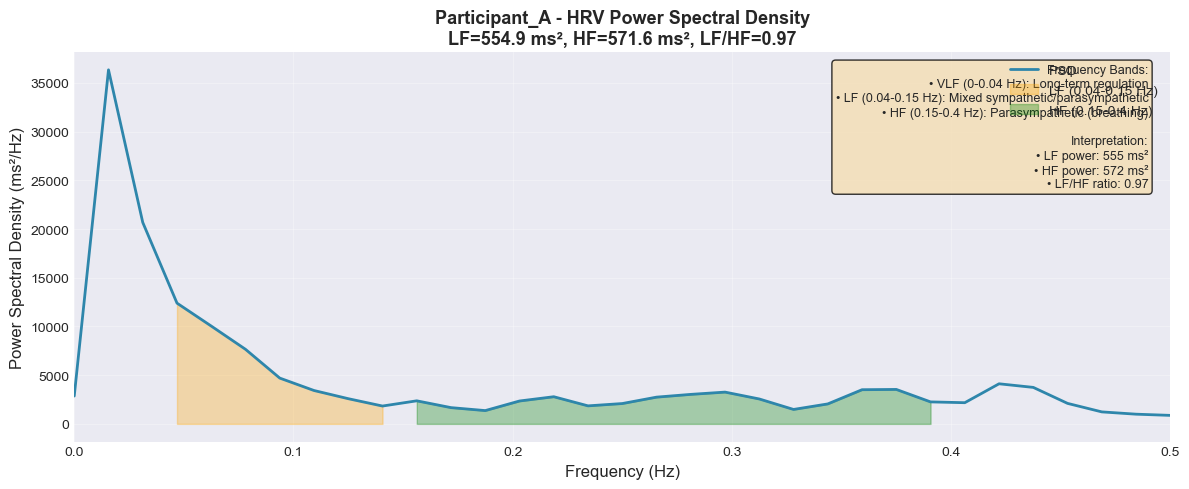

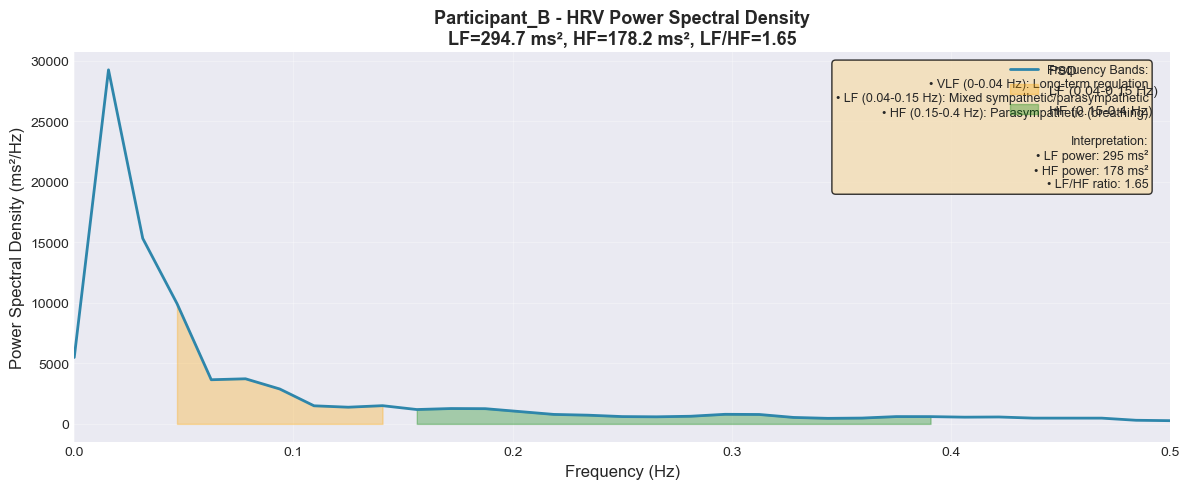

In [45]:
def plot_hrv_psd(rpeaks, sampling_rate, participant_name, hrv_metrics=None):
    """
    Plot Power Spectral Density of heart rate variability.
    Shows LF and HF bands.
    """
    from scipy import signal as sp_signal
    
    # Compute RR intervals
    rr_intervals = np.diff(rpeaks) / sampling_rate * 1000  # ms
    rr_times = rpeaks[:-1] / sampling_rate
    
    # Resample to regular time series (4 Hz)
    fs_rr = 4
    t_regular = np.arange(rr_times[0], rr_times[-1], 1/fs_rr)
    rr_regular = np.interp(t_regular, rr_times, rr_intervals)
    
    # Detrend
    rr_detrended = sp_signal.detrend(rr_regular)
    
    # Compute PSD
    freqs, psd = sp_signal.welch(rr_detrended, fs=fs_rr, nperseg=min(256, len(rr_detrended)))
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(freqs, psd, linewidth=2, color='#2E86AB', label='PSD')
    
    # Shade LF and HF bands
    lf_mask = (freqs >= 0.04) & (freqs < 0.15)
    hf_mask = (freqs >= 0.15) & (freqs < 0.4)
    
    ax.fill_between(freqs[lf_mask], 0, psd[lf_mask], alpha=0.3, color='orange', label='LF (0.04-0.15 Hz)')
    ax.fill_between(freqs[hf_mask], 0, psd[hf_mask], alpha=0.3, color='green', label='HF (0.15-0.4 Hz)')
    
    # Calculate powers
    lf_power = np.trapz(psd[lf_mask], freqs[lf_mask])
    hf_power = np.trapz(psd[hf_mask], freqs[hf_mask])
    
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (ms²/Hz)', fontsize=12)
    ax.set_title(f'{participant_name} - HRV Power Spectral Density\nLF={lf_power:.1f} ms², HF={hf_power:.1f} ms², LF/HF={(lf_power/hf_power if hf_power > 0 else 0):.2f}', 
                 fontsize=13, fontweight='bold')
    ax.set_xlim(0, 0.5)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add interpretation text
    textstr = '\n'.join([
        'Frequency Bands:',
        '• VLF (0-0.04 Hz): Long-term regulation',
        '• LF (0.04-0.15 Hz): Mixed sympathetic/parasympathetic',
        '• HF (0.15-0.4 Hz): Parasympathetic (breathing)',
        '',
        'Interpretation:',
        f'• LF power: {lf_power:.0f} ms²',
        f'• HF power: {hf_power:.0f} ms²',
        f'• LF/HF ratio: {(lf_power/hf_power if hf_power > 0 else 0):.2f}'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()

# Plot PSD for both participants
print("Creating Power Spectral Density plots...")
plot_hrv_psd(rpeaks_p1, metadata['sampling_rate_p1'], metadata['participant_1'], hrv_p1)
plot_hrv_psd(rpeaks_p2, metadata['sampling_rate_p2'], metadata['participant_2'], hrv_p2)

## 12. Visualizing HRV: Poincaré Plot

### Poincaré Plot:

A scatter plot of each RR interval against the next RR interval. Shape reveals:
- **SD1** (width): Short-term variability (beat-to-beat)
- **SD2** (length): Long-term variability
- **Pattern**: Healthy hearts show a "comet" shape

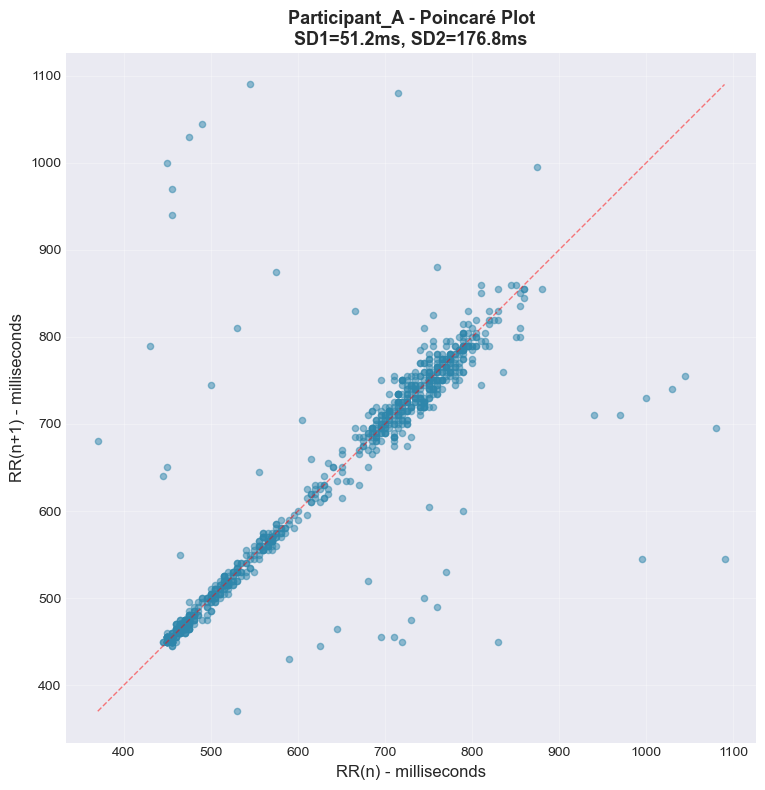

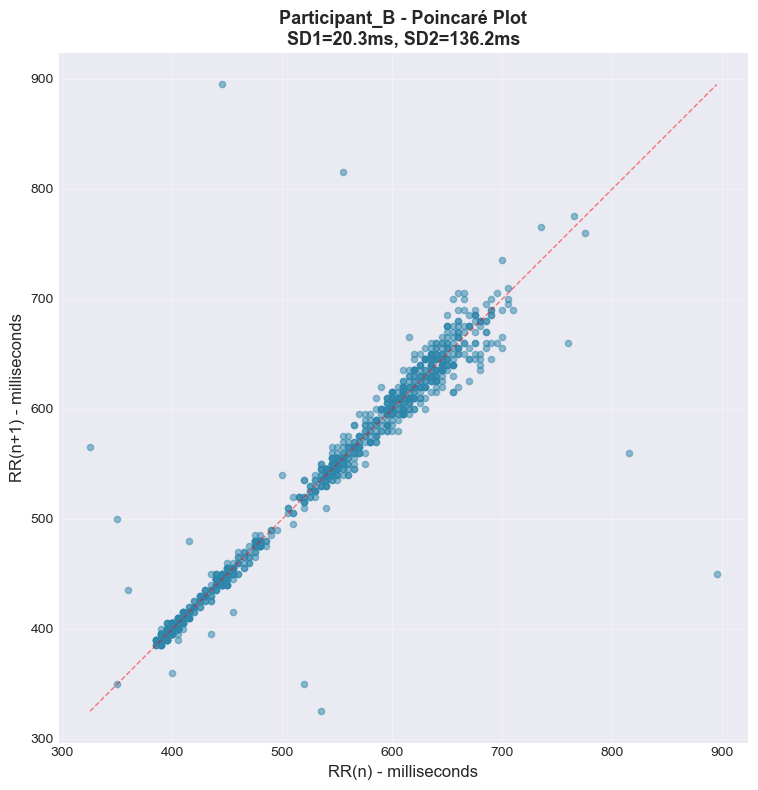

In [46]:
def plot_poincare(rr_intervals, participant_name):
    """
    Create Poincaré plot of RR intervals.
    """
    rr1 = rr_intervals[:-1]
    rr2 = rr_intervals[1:]
    
    # Calculate SD1 and SD2
    diff_rr = np.diff(rr_intervals)
    sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rr_intervals, ddof=1) ** 2 - 0.5 * np.std(diff_rr, ddof=1) ** 2)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(rr1, rr2, alpha=0.5, s=20, color='#2E86AB')
    
    # Add identity line
    min_rr = min(rr1.min(), rr2.min())
    max_rr = max(rr1.max(), rr2.max())
    ax.plot([min_rr, max_rr], [min_rr, max_rr], 'r--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('RR(n) - milliseconds', fontsize=12)
    ax.set_ylabel('RR(n+1) - milliseconds', fontsize=12)
    ax.set_title(f'{participant_name} - Poincaré Plot\nSD1={sd1:.1f}ms, SD2={sd2:.1f}ms', 
                 fontsize=13, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create Poincaré plots
plot_poincare(rr_p1, metadata['participant_1'])
plot_poincare(rr_p2, metadata['participant_2'])

## 13. R-Peak Based Synchrony Analysis

Now we'll compute synchrony using the precise R-peak timing, which gives us beat-to-beat coupling information.

In [47]:
def interpolate_hr_to_common_timebase(hr, rr_times, target_fs=4):
    """
    Interpolate heart rate to a common regular timebase.
    
    Parameters:
    - hr: Heart rate values (BPM)
    - rr_times: Times of heart rate values
    - target_fs: Target sampling frequency (Hz)
    
    Returns:
    - hr_interp: Interpolated HR
    - time_interp: Regular time base
    """
    # Create regular time base
    time_interp = np.arange(rr_times[0], rr_times[-1], 1/target_fs)
    
    # Interpolate HR
    hr_interp = np.interp(time_interp, rr_times, hr)
    
    return hr_interp, time_interp

# Interpolate both participants to same timebase
print("Interpolating heart rate to common timebase...")
hr_p1_interp, time_p1_interp = interpolate_hr_to_common_timebase(hr_p1, rr_times_p1)
hr_p2_interp, time_p2_interp = interpolate_hr_to_common_timebase(hr_p2, rr_times_p2)

# Trim to common time range
start_time = max(time_p1_interp[0], time_p2_interp[0])
end_time = min(time_p1_interp[-1], time_p2_interp[-1])

mask_p1 = (time_p1_interp >= start_time) & (time_p1_interp <= end_time)
mask_p2 = (time_p2_interp >= start_time) & (time_p2_interp <= end_time)

hr_p1_sync = hr_p1_interp[mask_p1]
hr_p2_sync = hr_p2_interp[mask_p2]
time_sync = time_p1_interp[mask_p1]

# Make absolutely sure they're the same length
min_len = min(len(hr_p1_sync), len(hr_p2_sync))
hr_p1_sync = hr_p1_sync[:min_len]
hr_p2_sync = hr_p2_sync[:min_len]
time_sync = time_sync[:min_len]

print(f"✓ Interpolated to {len(hr_p1_sync)} samples")
print(f"✓ Common time range: {start_time:.1f}s to {end_time:.1f}s")

Interpolating heart rate to common timebase...
✓ Interpolated to 2141 samples
✓ Common time range: 1.1s to 536.3s


In [48]:
# Compute correlation on interpolated HR
r_rpeak, p_rpeak = stats.pearsonr(hr_p1_sync, hr_p2_sync)

print("=" * 70)
print("R-PEAK BASED SYNCHRONY")
print("=" * 70)
print(f"\nPearson correlation: {r_rpeak:.3f}")
print(f"P-value: {p_rpeak:.4e}")
print(f"Number of samples: {len(hr_p1_sync)}")

if abs(r_rpeak) > 0.7:
    strength = "STRONG"
elif abs(r_rpeak) > 0.4:
    strength = "MODERATE"
elif abs(r_rpeak) > 0.2:
    strength = "WEAK"
else:
    strength = "LITTLE TO NO"

print(f"\n📊 {strength} synchrony detected")

R-PEAK BASED SYNCHRONY

Pearson correlation: 0.853
P-value: 0.0000e+00
Number of samples: 2141

📊 STRONG synchrony detected


## 14. Windowed Synchrony from R-Peaks

In [49]:
def windowed_synchrony_rpeaks(hr1, hr2, time_base, window_size_sec=30, overlap=0.5, fs=4):
    """
    Compute windowed correlation on R-peak based HR.
    """
    window_samples = int(window_size_sec * fs)
    step_samples = int(window_samples * (1 - overlap))
    
    correlations = []
    window_times = []
    
    for start in range(0, len(hr1) - window_samples, step_samples):
        end = start + window_samples
        
        window1 = hr1[start:end]
        window2 = hr2[start:end]
        
        r, _ = stats.pearsonr(window1, window2)
        correlations.append(r)
        
        center_time = time_base[start + window_samples // 2]
        window_times.append(center_time)
    
    return np.array(window_times), np.array(correlations)

# Compute windowed synchrony
times_rpeak, corr_rpeak = windowed_synchrony_rpeaks(hr_p1_sync, hr_p2_sync, time_sync)

print(f"Computed {len(corr_rpeak)} windows")
print(f"Mean correlation: {corr_rpeak.mean():.3f}")
print(f"Std: {corr_rpeak.std():.3f}")

Computed 34 windows
Mean correlation: 0.080
Std: 0.317


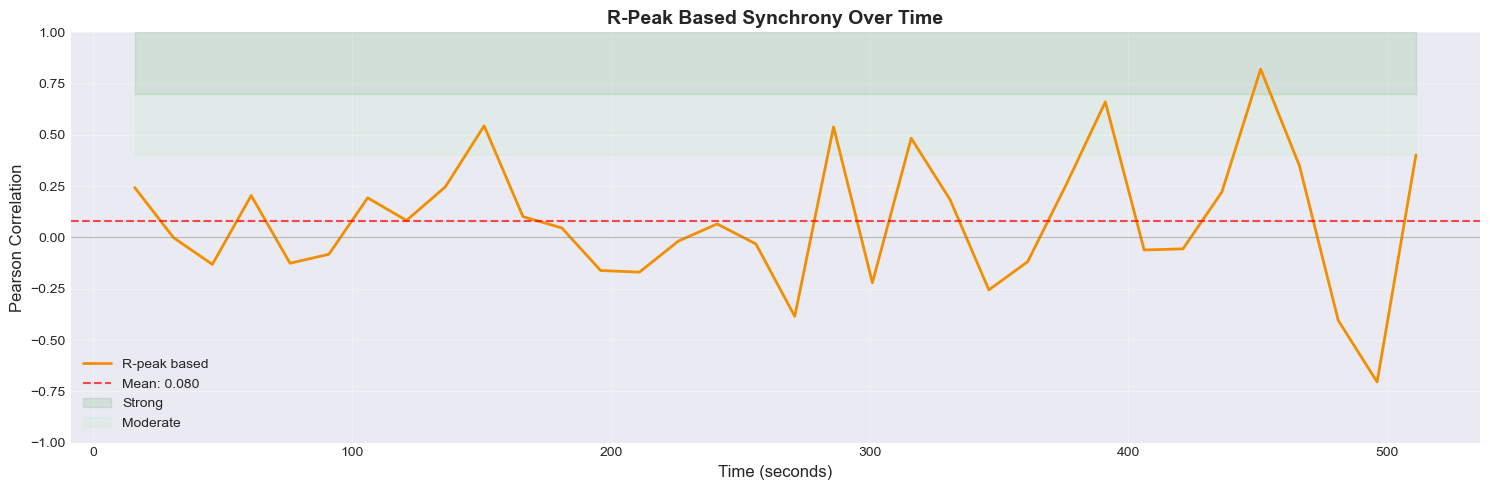

In [50]:
# Plot windowed synchrony
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(times_rpeak, corr_rpeak, linewidth=2, color='#F18F01', label='R-peak based')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axhline(corr_rpeak.mean(), color='red', linestyle='--', 
           linewidth=1.5, alpha=0.7, label=f'Mean: {corr_rpeak.mean():.3f}')

ax.fill_between(times_rpeak, 0.7, 1.0, alpha=0.1, color='green', label='Strong')
ax.fill_between(times_rpeak, 0.4, 0.7, alpha=0.1, color='lightgreen', label='Moderate')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.set_title('R-Peak Based Synchrony Over Time', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Comparison: Quick vs. Full Pipeline

In [51]:
# Save HRV metrics
output_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense-main/analysis_results")
output_dir.mkdir(exist_ok=True)

hrv_p1.to_csv(output_dir / f"hrv_{metadata['participant_1']}.csv", index=False)
hrv_p2.to_csv(output_dir / f"hrv_{metadata['participant_2']}.csv", index=False)

# Save R-peak based HR time series
hr_p1_df = pd.DataFrame({
    'Time': time_p1_interp,
    'HeartRate': hr_p1_interp
})
hr_p2_df = pd.DataFrame({
    'Time': time_p2_interp,
    'HeartRate': hr_p2_interp
})

hr_p1_df.to_csv(output_dir / f"hr_rpeak_{metadata['participant_1']}.csv", index=False)
hr_p2_df.to_csv(output_dir / f"hr_rpeak_{metadata['participant_2']}.csv", index=False)

# Save RR intervals (for Poincaré analysis and other HRV uses)
rr_p1_df = pd.DataFrame({
    'Time': rr_times_p1,
    'RR_interval': rr_p1,
    'HeartRate': hr_p1
})
rr_p2_df = pd.DataFrame({
    'Time': rr_times_p2,
    'RR_interval': rr_p2,
    'HeartRate': hr_p2
})

rr_p1_df.to_csv(output_dir / f"rr_intervals_{metadata['participant_1']}.csv", index=False)
rr_p2_df.to_csv(output_dir / f"rr_intervals_{metadata['participant_2']}.csv", index=False)

# Save synchrony results
synchrony_df = pd.DataFrame({
    'Time': times_rpeak,
    'Correlation': corr_rpeak
})
synchrony_df.to_csv(output_dir / "synchrony_rpeak_windowed.csv", index=False)

print(f"✓ Results saved to {output_dir}/")
print("\nFiles created:")
for file in output_dir.glob("*"):
    print(f"  - {file.name}")

✓ Results saved to /Users/lena/Downloads/tutorial_dyadic_movesense-main/analysis_results/

Files created:
  - rr_intervals_Participant_B.csv
  - rr_intervals_Participant_A.csv
  - hrv_Participant_A.csv
  - hrv_Participant_B.csv
  - hr_rpeak_Participant_B.csv
  - synchrony_rpeak_windowed.csv
  - hr_rpeak_Participant_A.csv


print("=" * 70)
print("PIPELINE COMPARISON")
print("=" * 70)

print("\n📊 QUICK PIPELINE (Pre-computed HR):")
print("  ⚡ Fast computation")
print("  ⚡ Good for real-time applications")
print("  ⚠ Limited HRV metrics")
print("  ⚠ Less granular than R-peak based")

print("\n📊 FULL PIPELINE (R-peak based):")
print("  ✓ Complete ECG preprocessing control")
print("  ✓ Comprehensive HRV analysis")
print("  ✓ Beat-to-beat precision")
print("  ✓ Research-grade metrics")
print(f"  ⏱️  Processing time: ~{(len(ecg_p1) + len(ecg_p2)) / 1000:.1f}x longer")

print("\n💡 RECOMMENDATIONS:")
print("  → Use QUICK pipeline for:")
print("     • Real-time monitoring")
print("     • Rapid exploratory analysis")
print("     • Simple synchrony assessment")
print("\n  → Use FULL pipeline for:")
print("     • Research publications")
print("     • Detailed physiological analysis")
print("     • HRV studies")
print("     • When you need R-peak timing")

---

## Try It Yourself!

### Exercise 1: Different Cleaning Methods
Try different ECG cleaning methods in `nk.ecg_clean()`:
- 'neurokit' (default)
- 'biosppy'
- 'pantompkins1985'
- 'hamilton2002'

Compare the results!

### Exercise 2: Advanced Synchrony Metrics
Implement phase synchrony using the Hilbert transform:
```python
from scipy.signal import hilbert
# Get instantaneous phases
phase1 = np.angle(hilbert(hr_p1_sync))
phase2 = np.angle(hilbert(hr_p2_sync))
# Compute phase locking value
phase_diff = phase1 - phase2
plv = np.abs(np.mean(np.exp(1j * phase_diff)))
```

### Exercise 3: Segment Analysis
If your experiment has distinct phases, analyze HRV and synchrony separately for each phase.

---

**